# Part 1: loads necessary modules and file paths 

In [58]:
from age_balance_analysis import biomass
%load_ext autoreload 
%autoreload 2
from typing import Tuple
import pandas as pd  # enables working with dataframes
import matplotlib.pyplot as plt  # a standard plotting package for python
import seaborn as sns  # extra tools for plotting (such as violin plots)
import numpy as np  # common mathematical functions
from pathlib import Path  # used for common file system operations
import networkx as nx  # package for plotting networks

from tqdm.notebook import tqdm  # in case tqdm does not work do: pip install --upgrade jupyter ipywidgets

from scipy.stats import linregress  # linear regression used for calculating the growth rates
from scipy.optimize import curve_fit  # curve fitting function used for fitting the M matrix parameters based on labelling data
from scipy.linalg import expm  # matrix exponent function (used in the calculation of the labelling function)

# set the specific style of the figures (white background with gridlines)
sns.set_style("whitegrid")

# define the paths to lysine exchange data files
DATA_PATH = Path("../data/lysine_vacule_knockouts")
METABOLIC_LABELLING_DATA_PATH = DATA_PATH / "2024-02-28_MS_metabolites_EO_1.tsv"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part 2: loads and plots raw lysine labelling data

experiment      condition strain       fraction pulse_type  temp_celsius  \
0           14  Y679 spike-in   Y679  total soluble   spike-in            30   
1           14  Y679 spike-in   Y679  total soluble   spike-in            30   
2           14  Y679 spike-in   Y679  total soluble   spike-in            30   
3           14  Y679 spike-in   Y679  total soluble   spike-in            30   
4           14  Y679 spike-in   Y679  total soluble   spike-in            30   
5           14  Y679 spike-in   Y679  total soluble   spike-in            30   
6           14  Y679 spike-in   Y679  total soluble   spike-in            30   
7           15  Y679 spike-in   Y679  total soluble   spike-in            30   
8           15  Y679 spike-in   Y679  total soluble   spike-in            30   
9           15  Y679 spike-in   Y679  total soluble   spike-in            30   
10          15  Y679 spike-in   Y679  total soluble   spike-in            30   
11          15  Y679 spike-in   Y679  total soluble   spike-in            30   
12          15  Y679 spike-in   Y679  total soluble   spike-in            30   
13          15  Y679 spike-in   Y679  total soluble   spike-in            30   
14          14  Y679 spike-in   Y679        protein   spike-in            30   
15          14  Y679 spike-in   Y679        protein   spike-in            30   
16          14  Y679 spike-in   Y679        protein   spike-in            30   
17          14  Y679 spike-in   Y679        protein   spike-in            30   
18          14  Y679 spike-in   Y679        protein   spike-in            30   
19          14  Y679 spike-in   Y679        protein   spike-in            30   
20          14  Y679 spike-in   Y679        protein   spike-in            30   
21          15  Y679 spike-in   Y679        protein   spike-in            30   
22          15  Y679 spike-in   Y679        protein   spike-in            30   
23          15  Y679 spike-in   Y679        protein   spike-in            30   
24          15  Y679 spike-in   Y679        protein   spike-in            30   
25          15  Y679 spike-in   Y679        protein   spike-in            30   
26          15  Y679 spike-in   Y679        protein   spike-in            30   
27          15  Y679 spike-in   Y679        protein   spike-in            30   

    time_min  replicate metabolite  labelling  growth_dilution  signal_H  \
0          5          1  Lys0;Lys8   0.376624         0.947574       NaN   
1         10          1  Lys0;Lys8   0.278205         0.802569       NaN   
2         20          1  Lys0;Lys8   0.198911         0.829352       NaN   
3         30          1  Lys0;Lys8   0.162844         0.735621       NaN   
4         45          1  Lys0;Lys8   0.134033         0.666159       NaN   
5         60          1  Lys0;Lys8   0.115560         0.600329       NaN   
6         90          1  Lys0;Lys8   0.095968         0.483850       NaN   
7          5          2  Lys0;Lys8   0.404910         0.910355       NaN   
8         10          2  Lys0;Lys8   0.302344         0.722478       NaN   
9         20          2  Lys0;Lys8   0.216251         0.675072       NaN   
10        30          2  Lys0;Lys8   0.180187         0.644068       NaN   
11        45          2  Lys0;Lys8   0.149566         0.609100       NaN   
12        60          2  Lys0;Lys8   0.130497         0.518030       NaN   
13        90          2  Lys0;Lys8   0.109510         0.414789       NaN   
14         5          1  Lys0;Lys8   0.959102         0.947574       NaN   
15        10          1  Lys0;Lys8   0.932389         0.802569       NaN   
16        20          1  Lys0;Lys8   0.880022         0.829352       NaN   
17        30          1  Lys0;Lys8   0.827633         0.735621       NaN   
18        45          1  Lys0;Lys8   0.755364         0.666159       NaN   
19        60          1  Lys0;Lys8   0.688172         0.600329       NaN   
20        90          1  Lys0;Lys8   0.577018         0.483850       NaN   
21         

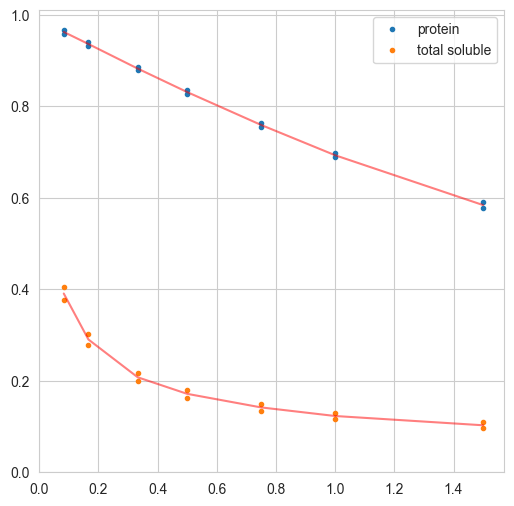

In [59]:
# read the TAB-delimited lysine exchange data into a dataframe
labelling_df = pd.read_csv(METABOLIC_LABELLING_DATA_PATH, delimiter="\t")

# display the imported dataset 
display(labelling_df)

# convert time points form minutes to hours
labelling_df["time_h"] = labelling_df.time_min / 60.0

# create the figure canvas and axes for plotting
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)

# iterates over labelling data in different fractions
for fract, group_df in labelling_df.groupby("fraction"):
    
    # calculate the mean over replicates
    ax.plot(group_df.time_h, group_df.labelling, ".", label=fract)
    mean_values = group_df.groupby("time_h").mean("labelling")
    ax.plot(mean_values.index, mean_values.labelling, "r-", alpha=0.5, label=None)

# add a figure legend
ax.legend()

# set the x and y axes limits
ax.set_ylim(0, 1.01)
ax.set_xlim(0, None)

# save the plot to the file system
plt.savefig("raw_lysine_labelling.pdf", format="pdf", bbox_inches="tight")

In [60]:
mean_values

experiment  temp_celsius  time_min  replicate  labelling  \
time_h                                                               
0.083333        14.5          30.0       5.0        1.5   0.390767   
0.166667        14.5          30.0      10.0        1.5   0.290274   
0.333333        14.5          30.0      20.0        1.5   0.207581   
0.500000        14.5          30.0      30.0        1.5   0.171516   
0.750000        14.5          30.0      45.0        1.5   0.141799   
1.000000        14.5          30.0      60.0        1.5   0.123029   
1.500000        14.5          30.0      90.0        1.5   0.102739   

          growth_dilution  signal_H  signal_L  signal_tot  
time_h                                                     
0.083333         0.928965       NaN       NaN         NaN  
0.166667         0.762523       NaN       NaN         NaN  
0.333333         0.752212       NaN       NaN         NaN  
0.500000         0.689844       NaN       NaN         NaN  
0.750000         0.637630       NaN       NaN         NaN  
1.000000         0.559180       NaN       NaN         NaN  
1.500000         0.449319       NaN       NaN         NaN

In [61]:
# display raw lysine labelling data for fitting
labelling_df.loc[labelling_df.fraction == "total soluble", ["experiment", "strain", "pulse_type", "temp_celsius", "time_min", "replicate"]]

experiment strain pulse_type  temp_celsius  time_min  replicate
0           14   Y679   spike-in            30         5          1
1           14   Y679   spike-in            30        10          1
2           14   Y679   spike-in            30        20          1
3           14   Y679   spike-in            30        30          1
4           14   Y679   spike-in            30        45          1
5           14   Y679   spike-in            30        60          1
6           14   Y679   spike-in            30        90          1
7           15   Y679   spike-in            30         5          2
8           15   Y679   spike-in            30        10          2
9           15   Y679   spike-in            30        20          2
10          15   Y679   spike-in            30        30          2
11          15   Y679   spike-in            30        45          2
12          15   Y679   spike-in            30        60          2
13          15   Y679   spike-in            30        90          2

# Part 3: defines and parametrises a KSM based on experimental lysine labelling

convert the parameters to a $M$ matrix for a model with 3 states:
- $\rightarrow S_0$
- $\rightarrow  S_1$
- $S_0 \rightarrow S_2$
- $S_1 \rightarrow S_2$

where the measured labelling is only for $S_2$.

In this part, we fit the $M$ matrix with the unknown fractional transfer coefficients as free parameters, see Appendix 4.7 for the examples of $M$ matrix construction. 

In [62]:
#EO: depiction of KSM matrix with the unknown fractional transfer rates as free parameters (see Apendix 4.7)
M_def = {'s0': ["-p0", "0.0", "1000.0*p2"],
         's1': ["0.0", "-p1", "1000.0*(1.0-p2)"],
         's2': ["0.0", "0.0", "-1000.0"]}
M_def = pd.DataFrame(M_def)
new_row_names = ['s0', 's1', 's2']
M_def = M_def.rename(index=dict(zip(M_def.index, new_row_names)))
display("KSM matrix: ", M_def)

'KSM matrix: '

s0               s1       s2
s0        -p0              0.0      0.0
s1        0.0              -p1      0.0
s2  1000.0*p2  1000.0*(1.0-p2)  -1000.0

In [63]:
def f_free_lysine(_tdata: np.ndarray, *x) -> np.ndarray:
    """Calculate the labelling fraction based on the input parameters and time series."""
    p0, p1, p2 = tuple(x)
    M = np.array([[-p0, 0.0, 0.0], [0.0, -p1, 0.0], [1000.0*p2, 1000.0*(1.0-p2), -1000.0]])

    # 1-vector for labelling computation. See Appendix eq.(7)
    ones = np.ones(M.shape[0])

    # observed pools, fractional distribution - here we only observe the 3rd pool (S2)
    s = np.array([0.0, 0.0, 1.0], ndmin=1)
    try:
        return np.array([s @ expm(M * t) @ ones for t in _tdata.flat])
    except RuntimeError:
        # return f(t) = 1 if labelling computation fails
        return np.ones(tdata.shape)

In [78]:
#EO: this is very good but a bit connfuring:
#EO: 1. why would you have loops in each state?  EN: these should be outgoing transfer rates (to external pools), I couldn't manage yet to draw that well
#EO: 2. the fractional tranfer values are not visipble  EN: hope it's easier now
#EO: 3. external flux arrows that supplly s0 and s1 are issing (minor issue)   EN: good point, but what this shows is not flux but fractional transfer rates...

def draw_transition_matrix(ax: plt.Axes, M: np.ndarray, seed: int = 13648) -> None:
    G = nx.Graph()
    edge_labels = {}
    for i in range(M.shape[0]):
        influx = -M[i, :].sum()
        if influx >= 1e-3:
            G.add_edge(f"i{i}", f"s{i}", weight=3)
            edge_labels[(f"i{i}", f"s{i}")] = influx.round(2)
        for j in range(M.shape[1]):
            if i == j:
                continue
            if np.abs(M[i, j]) < 1e-3:
                continue
            G.add_edge(f"s{j}", f"s{i}", weight=1)
            edge_labels[(f"s{j}", f"s{i}")] = M[i, j].round(2)

    # instead of the diagonal values, show the row sum as the turnover contributed by the external state

    pos = nx.spring_layout(G, seed=seed)
    nx.draw_networkx_nodes(G, pos=pos, node_size=400, ax=ax)  # draw nodes and edges
    nx.draw_networkx_labels(G, pos=pos, ax=ax)  # draw node labels
    nx.draw_networkx_edges(G, pos=pos, arrowstyle="->", arrowsize=30, arrows=True, width=1, ax=ax)
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, ax=ax)  # draw edge weights

'M = '

array([[ -19.55,    0.  ,    0.  ],
       [   0.  ,   -0.77,    0.  ],
       [  72.94,   27.06, -100.  ]])

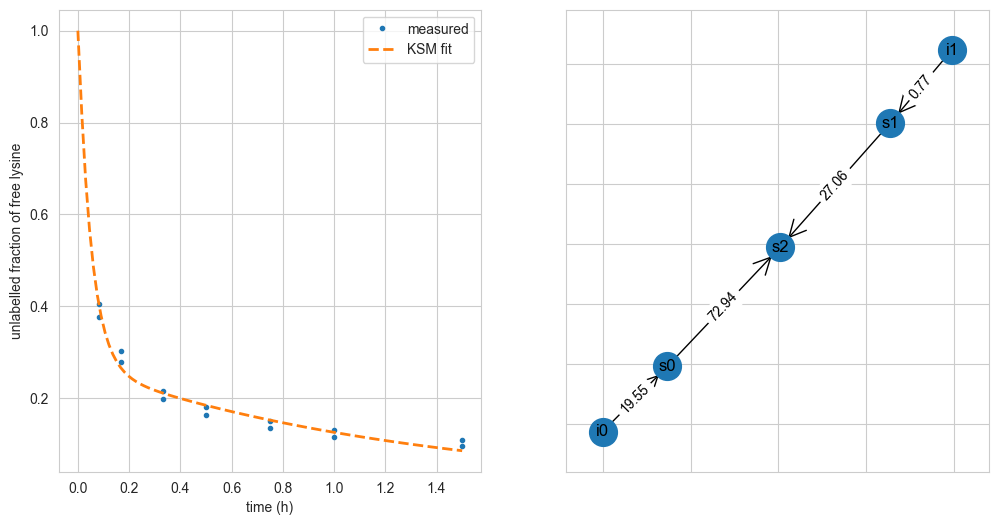

In [79]:
# select the total soluble freaction only
total_soluble_df = labelling_df[labelling_df.fraction == "total soluble"]

# calculate the mean over all replicates
data_mean = total_soluble_df.groupby("time_h")[["labelling"]].mean().reset_index()

# fit the KSM parapeters
res = curve_fit(
    f=f_free_lysine,  # the KSM itself
    xdata=data_mean.time_h.values,  # experimental data time series
    ydata=data_mean.labelling.values,  # experimental data labelling series
    p0=np.ones(3),  # initial KSM parameters
    bounds=[(1e-3, 1e-3, 0), (1e2, 1e2, 1)]  # allowed parameter ranges
)
lysine_popt, lysine_pcov = res
_p0, _p1, _p2 = tuple(lysine_popt)
lysine_M = np.array([[-_p0, 0.0, 0.0], [0.0, -_p1, 0.0], [100.0*_p2, 100.0*(1.0-_p2), -100.0]])
display("M = ", lysine_M.round(2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# plot raw measured labelling data 
total_soluble_df.plot(x="time_h", y="labelling", linewidth=0, marker=".", label="measured", ax=axs[0])

# define the range of time points for plotting
tdata = np.linspace(start=0, stop=1.5, num=100)
axs[0].plot(tdata, f_free_lysine(tdata, *lysine_popt), "--", linewidth=2, label="KSM fit")

axs[0].set_xlabel("time (h)")
axs[0].set_ylabel("unlabelled fraction of free lysine")
axs[0].legend()

draw_transition_matrix(axs[1], lysine_M)

# save the plot
fig.savefig("lysine_labelling_fit.pdf", format="pdf", bbox_inches="tight")

# Part 4: determines and plots growth rates for protein labelling experiments

In [66]:
# load the raw protein labelling data into a dataframe
LABELLING_DATA_PATH = DATA_PATH / "2024-03-07_MS_proteins_EO_8._exp9-12.tsv"
unfractionated_df = pd.read_csv(LABELLING_DATA_PATH, delimiter="\t")

# convert time points form minutes to hours
unfractionated_df["time_h"] = unfractionated_df.time_min / 60.0
display(unfractionated_df)

experiment                 condition strain           pulse_type  \
0               9  Y679 spike-in timecourse   Y679  spike-in timecourse   
1               9  Y679 spike-in timecourse   Y679  spike-in timecourse   
2               9  Y679 spike-in timecourse   Y679  spike-in timecourse   
3               9  Y679 spike-in timecourse   Y679  spike-in timecourse   
4               9  Y679 spike-in timecourse   Y679  spike-in timecourse   
...           ...                       ...    ...                  ...   
21895          12  Y679 spike-in timecourse   Y679  spike-in timecourse   
21896          12  Y679 spike-in timecourse   Y679  spike-in timecourse   
21897          12  Y679 spike-in timecourse   Y679  spike-in timecourse   
21898          12  Y679 spike-in timecourse   Y679  spike-in timecourse   
21899          12  Y679 spike-in timecourse   Y679  spike-in timecourse   

       temp_celsius  time_min  replicate         gene      gene_id channel  \
0                30       150          1  HSP82_HSC82  HSP82_HSC82      K1   
1                30       150          1  HSP82_HSC82  HSP82_HSC82      K2   
2                30        60          1  HSP82_HSC82  HSP82_HSC82      K1   
3                30        10          1  HSP82_HSC82  HSP82_HSC82      K1   
4                30        60          1  HSP82_HSC82  HSP82_HSC82      K2   
...             ...       ...        ...          ...          ...     ...   
21895            37        10          2        RPC82      YPR190C      K1   
21896            37       150          2         QCR2      YPR191W      K2   
21897            37       150          2         QCR2      YPR191W      K1   
21898            37        60          2         QCR2      YPR191W      K1   
21899            37        10          2         QCR2      YPR191W      K1   

       precursor_no  labelling  growth_dilution      signal_H      signal_L  \
0                49   0.449216         0.402903  4.599503e+07  3.650336e+07   
1                10   0.490947         0.402903  2.263859e+05  2.108314e+05   
2                47   0.737368         0.669397  2.256367e+07  6.019864e+07   
3                39   0.960900         0.933672  3.334023e+06  7.455006e+07   
4                 9   0.794243         0.669397  8.622818e+04  3.466145e+05   
...             ...        ...              ...           ...           ...   
21895             3   0.878921         0.943891  3.567421e+03  2.097543e+04   
21896             3   0.454116         0.419662  1.028366e+05  8.095659e+04   
21897            21   0.442080         0.419662  2.685823e+06  2.014189e+06   
21898            20   0.773786         0.693894  7.222972e+05  2.400950e+06   
21899            11   0.973871         0.943891  6.107658e+04  1.696071e+06   

         signal_tot    time_h  
0      8.249839e+07  2.500000  
1      4.372173e+05  2.500000  
2      8.276230e+07  1.000000  
3      7.788409e+07  0.166667  
4      4.328426e+05  1.000000  
...             ...       ...  
21895  2.454285e+04  0.166667  
21896  1.837931e+05  2.500000  
21897  4.700012e+06  2.500000  
21898  3.123247e+06  1.000000  
21899  1.757148e+06  0.166667  

[21900 rows x 17 columns]

condition strain           pulse_type  \
experiment                                                         
9           Y679 spike-in timecourse   Y679  spike-in timecourse   
10          Y679 spike-in timecourse   Y679  spike-in timecourse   
11          Y679 spike-in timecourse   Y679  spike-in timecourse   
12          Y679 spike-in timecourse   Y679  spike-in timecourse   

            temp_celsius  num_time_points  growth_rate  
experiment                                              
9                     30                3     0.362890  
10                    30                3     0.358581  
11                    37                3     0.339105  
12                    37                3     0.347735

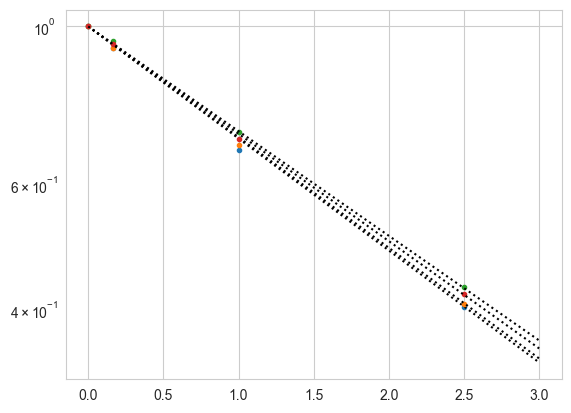

In [67]:
# format conditions and number of labelling time points in experiments 
metadata_df = unfractionated_df[
    ["experiment", "condition", "strain", "pulse_type", "temp_celsius", "time_h"]
].drop_duplicates()
metadata_df = metadata_df.groupby(["experiment", "condition", "strain", "pulse_type", "temp_celsius"]).count().time_h.reset_index().set_index("experiment")
metadata_df.rename(columns={"time_h": "num_time_points"}, inplace=True)

# select the experiments for fitting
EXPERIMENTS_FOR_FITTING = [9, 10, 11, 12]
metadata_df = metadata_df.loc[EXPERIMENTS_FOR_FITTING, :]

fig, ax = plt.subplots(1, 1)

# data structures for collecting and plotting growth rates
growth_rates = {}

# Use the Biomass data to calculate the growth rates
# use log-scaled growth_dilution data and linear regression to calculate the growth rates
for idx, group_df in unfractionated_df.groupby(["experiment"]):
    biomass_df = group_df.groupby(["time_h"]).growth_dilution.mean().reset_index()
    tdata = [0.0] + biomass_df.time_h.values.tolist()
    bdata = [0.0] + np.log(biomass_df.growth_dilution.values).tolist()
    
    linreg_result = linregress(tdata, bdata)
    growth_rates[idx] = -linreg_result.slope
    ax.plot(tdata, np.exp(bdata), ".", label=f"Exp_{idx[0]}, $\\beta$ = {growth_rates[idx]:.3g}, [1/h]")
    ax.plot([0, 3], [1, np.exp(-growth_rates[idx] * 3)], 'k:')

ax.set_yscale("log")  #growth dilution in log-ascale for plotting
plt.savefig("growth_rate_biomass_fitting.pdf", format="pdf", bbox_inches="tight")

metadata_df = metadata_df.join(pd.Series(growth_rates, name="growth_rate"),
                               on="experiment")  #appends calculated growth rates
display(metadata_df)

# Part 5: parameterize protein labelling KSM

function for fitting protein pool based on the metabolomics result, including 4 states:
- $\rightarrow S_0$
- $\rightarrow  S_1$
- $S_0 \rightarrow S_2$
- $S_1 \rightarrow S_2$
- $S_2 \rightarrow S_3$

where the parameters are all taken from the previous fit to the free lysine labelling (Part 3), and
the only fitted parameter is the fractional transfer coeffitients from $S_2$ to $S_3$.
The measured labelling is assumed to represent $S_3$ only.

(see Apendix 4.7 for the examples of $M$ matrix construction)


In [68]:
# depiction of protein labelling KSM matrix (see Apendix 4.7)
# _opt = fitted parameters for lysine input
M_def = {'s0': ["-p0", "0.0", "1000.0*p2","0.0"],
         's1': ["0.0", "-p1", "1000.0*(1.0-p2)","0.0"],
         's2': ["0.0", "0.0", "-1000.0", "p3"],
         's3': ["0.0", "0.0", "0.0", "-p3"]}
M_def = pd.DataFrame(M_def)
new_row_names = ['s0', 's1', 's2','s4']
M_def = M_def.rename(index=dict(zip(M_def.index, new_row_names)))
display("protein labelling KSM matrix: ", M_def)

'protein labelling KSM matrix: '

s0               s1       s2   s3
s0        -p0              0.0      0.0  0.0
s1        0.0              -p1      0.0  0.0
s2  1000.0*p2  1000.0*(1.0-p2)  -1000.0  0.0
s4        0.0              0.0       p3  -p3

In [69]:
# define protein KSM fitting function

def popt_to_matrices(*x) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Converts the input parameters to (s, M, 1)."""
    p3, = tuple(x)

    # take the 3x3 matrix from the free lysine fit, and add another row and column to it
    n = lysine_M.shape[0]
    M = np.zeros((n+1, n+1))
    M[:n, :n] = lysine_M

    # add the transition from the measured free lysine pool to the protein pool (the added new state)
    M[n, n-1] = p3
    M[n, n] = -p3

    # observed pools, fractional distribution - only S3 is measured
    s = np.zeros(M.shape[0])
    s[-1] = 1

    # 1-vector for labelling computation. See Appendix eq.(7)
    ones = np.ones(M.shape[0])

    return s, M, ones

def f_protein(tdata: np.ndarray, *x) -> np.ndarray:
    s, M, ones = popt_to_matrices(*x)

    try:
        return np.array([s @ expm(M * t) @ ones for t in tdata.flat])
    except RuntimeError:
        # return f(t) = 1 if labelling computation fails
        return np.ones(tdata.shape)

def fit_f_protein(xdata, ydata, n_parameters: int = 1):
    # see Part 3 for optimisation function derails
    try:
        result = curve_fit(
            f=f_protein,
            xdata=xdata,
            ydata=ydata,
            p0=np.ones(n_parameters),
            bounds=[[1e-3]*n_parameters, [1e3]*n_parameters],
            full_output=False
        )
        popt, pcov = result
        mse = np.mean((ydata - f_protein(xdata, *popt)) ** 2)
        return popt, pcov, mse
    except RuntimeError:
        # returns ones if optimisation fails
        return np.ones(n_parameters), np.eye(n_parameters), np.nan

In [70]:
# collect fitting results: fitted prametes, error, fit mse
result_list = []

# define data for fitting
# EN: it looks like you only chose one time point for the fitting, why?
filtered_df = unfractionated_df[
    (unfractionated_df.channel == "K1") &
    (unfractionated_df.precursor_no > 2) &
    (unfractionated_df.time_min == 10)
]

for experiment, row in metadata_df.iterrows():
    _df = filtered_df[filtered_df.experiment == experiment].pivot(
        index="gene", columns="time_h", values="labelling"
    ).dropna()

    for idx in tqdm(_df.index, desc=f"Exp_{experiment}"):
        tdata = _df.columns.to_numpy()
        ydata = _df.loc[idx, :].to_numpy()
        popt, pcov, mse = fit_f_protein(tdata, ydata)
        result_list.append((experiment, idx, popt[0], np.sqrt(pcov[0, 0]), mse))

Exp_9:   0%|          | 0/1380 [00:00<?, ?it/s]

/tmp/ipykernel_305571/2232892521.py:37: OptimizeWarning: Covariance of the parameters could not be estimated
  result = curve_fit(


Exp_10:   0%|          | 0/1380 [00:00<?, ?it/s]

/tmp/ipykernel_305571/2232892521.py:37: OptimizeWarning: Covariance of the parameters could not be estimated
  result = curve_fit(


Exp_11:   0%|          | 0/1352 [00:00<?, ?it/s]

/tmp/ipykernel_305571/2232892521.py:37: OptimizeWarning: Covariance of the parameters could not be estimated
  result = curve_fit(


Exp_12:   0%|          | 0/1352 [00:00<?, ?it/s]

/tmp/ipykernel_305571/2232892521.py:37: OptimizeWarning: Covariance of the parameters could not be estimated
  result = curve_fit(


In [71]:
# display and save the fitting results
result_df = pd.DataFrame(result_list, columns=["experiment", "gene", "p3", "p3_std", "mse"])
display(result_df)
result_df.to_csv('results_protein_KSM.csv', index=False)

experiment  gene        p3  p3_std           mse
0              9  AAH1  0.501567     inf  9.386015e-24
1              9  AAP1  2.084057     inf  1.232595e-32
2              9  AAT1  1.040212     inf  2.151909e-21
3              9  AAT2  0.405166     inf  7.566836e-19
4              9  ABF1  3.345662     inf  0.000000e+00
...          ...   ...       ...     ...           ...
5459          12  ZPR1  0.308946     inf  9.698805e-15
5460          12  ZRT1  1.334108     inf  1.509929e-27
5461          12  ZTA1  1.113521     inf  1.109336e-31
5462          12  ZUO1  0.423255     inf  1.059796e-19
5463          12  ZWF1  0.323980     inf  2.449887e-15

[5464 rows x 5 columns]

(0.1, 100)

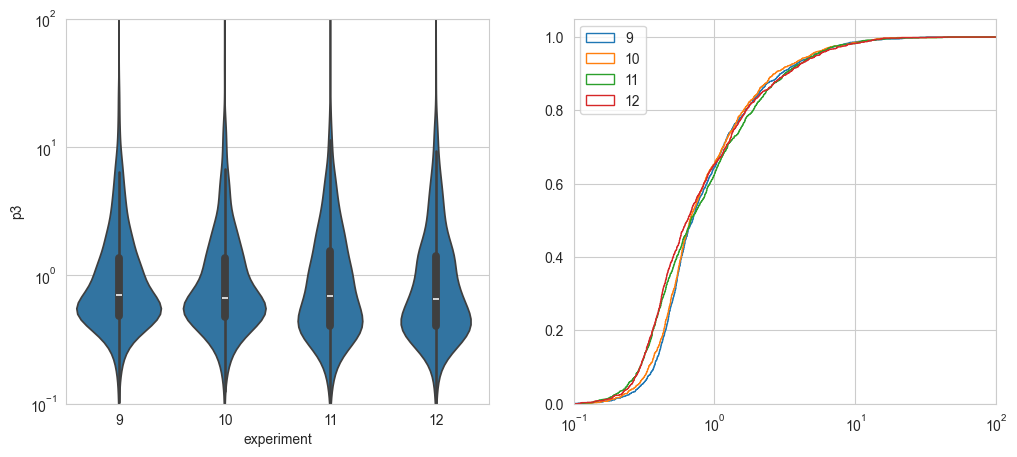

In [72]:
#EO: why p3 < 1 ?
#EN: this was a mistake, it was left from a previous definition of M, but doesn't make sense now. anyhow, the values are almost never > 1.
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.violinplot(data=result_df, x="experiment", y="p3", log_scale=True, ax=axs[0])
axs[0].set_ylim([0.1, 100])
for exp, group_df in result_df.groupby("experiment"):
    axs[1].hist(group_df.p3, bins=np.logspace(-1, 2.1, 1000), density=True, cumulative=True, histtype="step", label=exp)
axs[1].legend()
axs[1].set_xscale("log")
axs[1].set_xlim([0.1, 100])

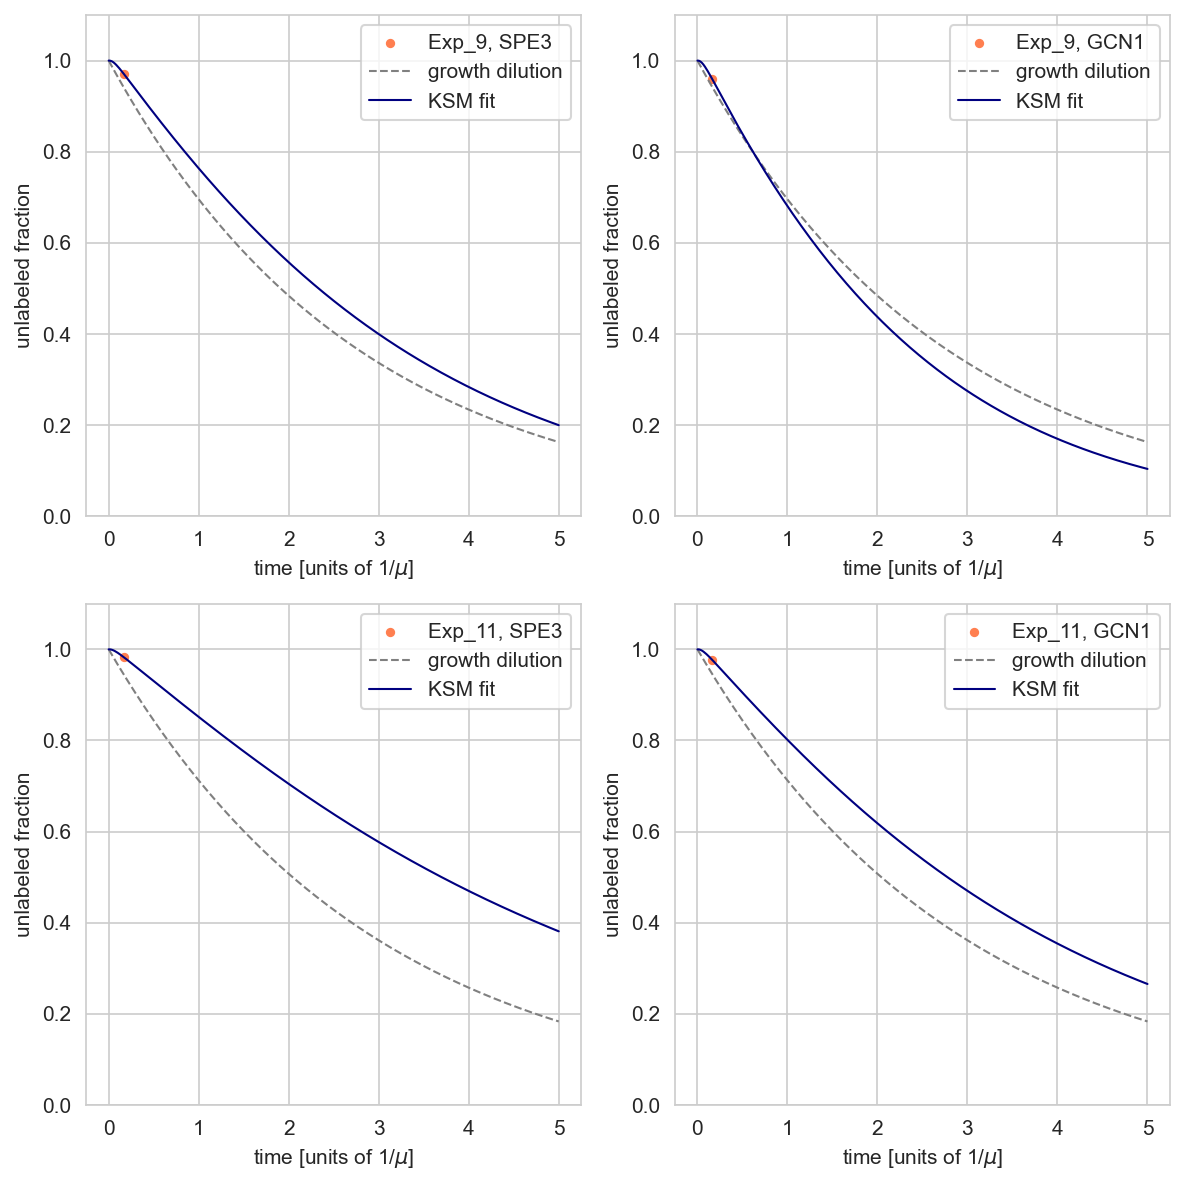

In [80]:
#EO: makes sense to:
#EO: - add growth dilution curve considering the lysine input
#EO: - add protein labelling curve w/o lysine linput (as step-function)
#EO: - add to the legend the average age values with an without lysine input

p3_dict = result_df.set_index(["experiment", "gene"]).p3.to_dict()

# here you can select two genes and two experiment numbers to show fiting results
exp_1 = 9
exp_2 = 11
gene_1 = "SPE3"
gene_2 = "GCN1"

fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=150)

for i, exp in enumerate([exp_1, exp_2]):
    growth_rate = metadata_df.loc[exp, "growth_rate"]
    _df = filtered_df[filtered_df.experiment == exp].pivot(index="gene", columns="time_h", values="labelling")
    for j, gene in enumerate([gene_1, gene_2]):
        ax = axs[i, j]
        xdata = _df.columns.to_numpy()
        ydata = _df.loc[gene, :].to_numpy()

        t_range = np.linspace(start=0, stop=5, num=300)
    
        ydata_growth = np.array([np.exp(-growth_rate * t) for t in t_range])
        ydata_pred = f_protein(t_range, p3_dict[(exp, gene)])
    
        ax.scatter(xdata, ydata, color="coral", s=12, label=f"Exp_{exp}, {gene}")
        ax.plot(t_range, ydata_growth, '--', color="grey", linewidth=1,
                label="growth dilution")
        ax.plot(t_range, ydata_pred, '-', color="navy", linewidth=1, label="KSM fit")
        ax.set_ylim(0, 1.1)
        ax.set_ylabel("unlabeled fraction")
        ax.set_xlabel("time [units of 1/$\\mu$]")
        ax.legend()
fig.tight_layout()

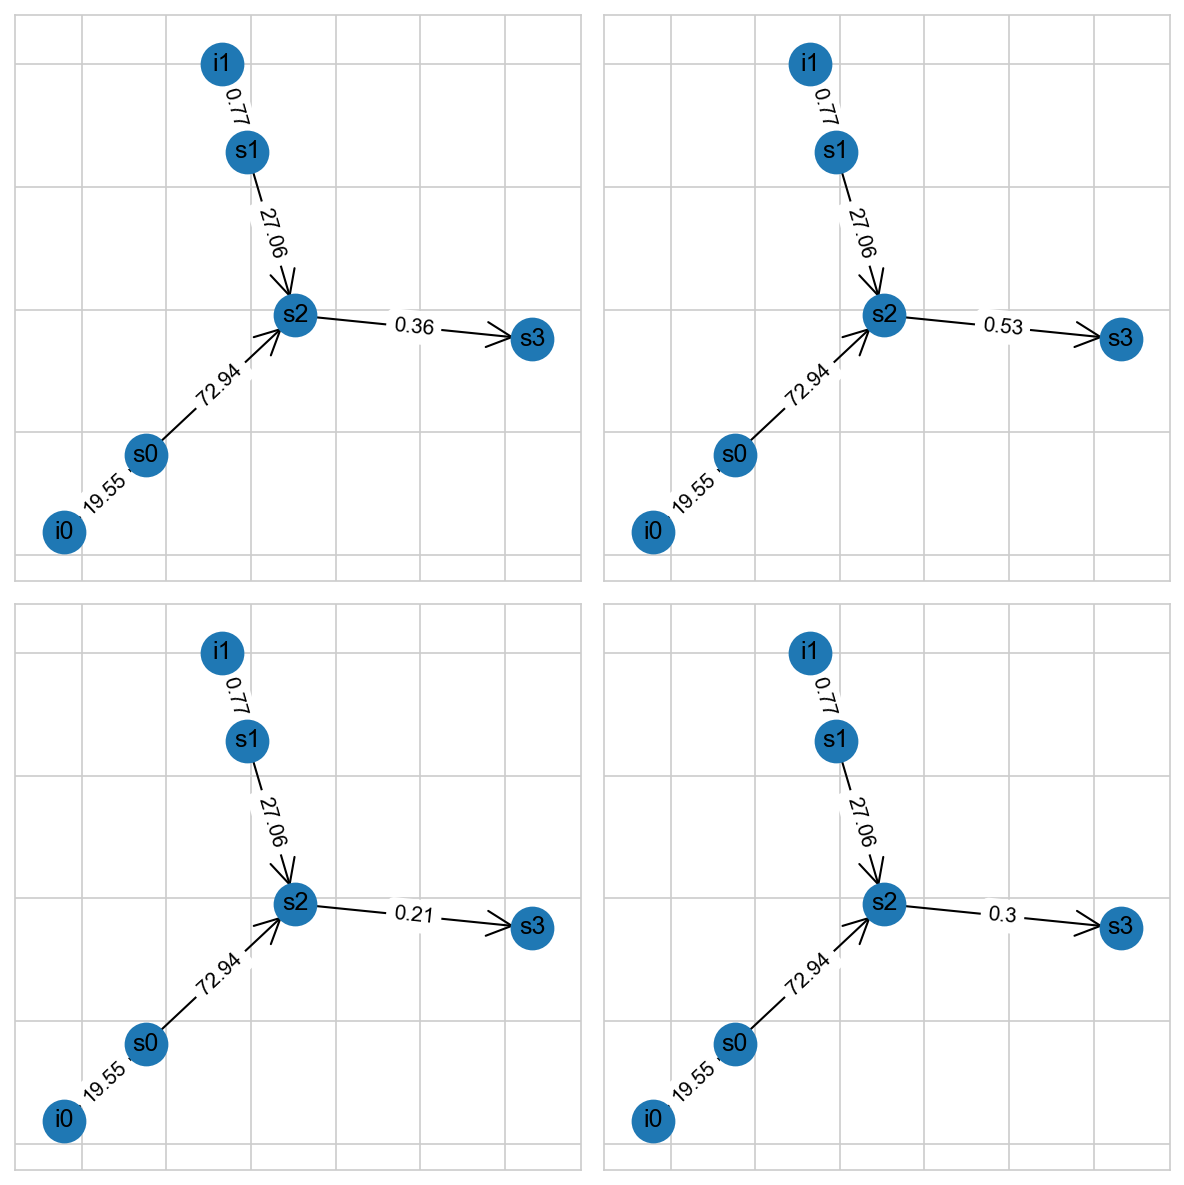

In [81]:
#EO: makes sense to:
#EO: - add growth dilution curve considering the lysine input
#EO: - add protein labelling curve w/o lysine linput (as step-function)
#EO: - add to the legend the average age values with an without lysine input

p3_dict = result_df.set_index(["experiment", "gene"]).p3.to_dict()

# here you can select two genes and two experiment numbers to show fiting results
exp_1 = 9
exp_2 = 11
gene_1 = "SPE3"
gene_2 = "GCN1"

fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=150)

for i, exp in enumerate([exp_1, exp_2]):
    growth_rate = metadata_df.loc[exp, "growth_rate"]
    _df = filtered_df[filtered_df.experiment == exp].pivot(index="gene", columns="time_h", values="labelling")
    for j, gene in enumerate([gene_1, gene_2]):
        ax = axs[i, j]
        s, M, ones = popt_to_matrices(p3_dict[(exp, gene)])
        draw_transition_matrix(ax, M)
fig.tight_layout()

Probability Distribution Functions (p.d.f):
- age : $-\mathbf{s}^\top \mathbf{M} e^{\mathbf{M}t} \mathbf{1_n} ~\big/~ \mathbf{s}^\top \mathbf{1_n}$
- transit-time: $-\mathbf{s}^\top \mathbf{M}^2 e^{\mathbf{M}t} \mathbf{1_n} ~\big/~ \mathbf{s}^\top \mathbf{M} \mathbf{1_n}$

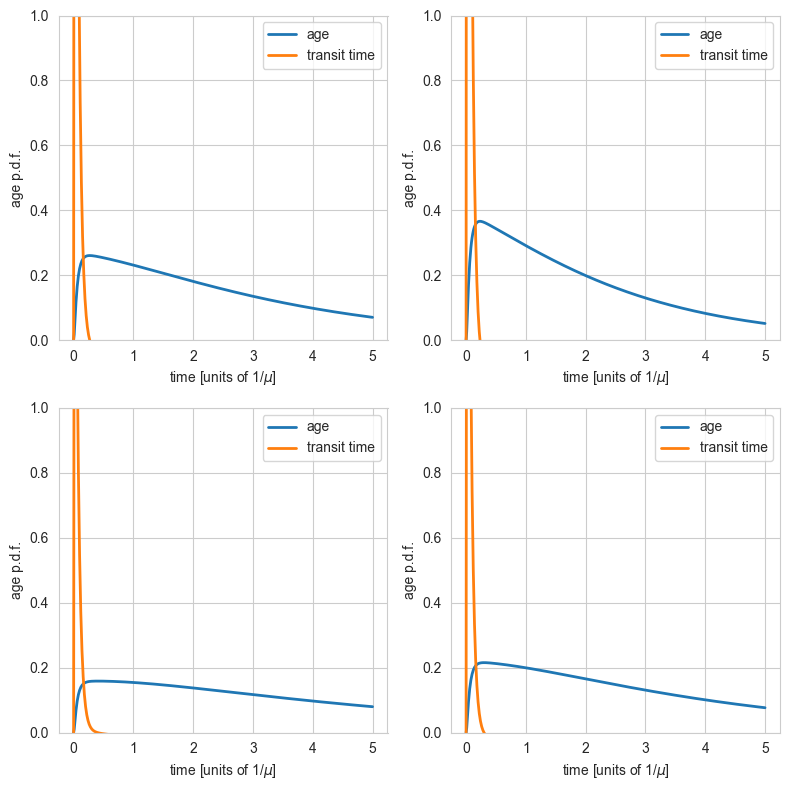

In [82]:
#EO: this look very nice. 
#EO: one can perhaps focus on the age only (not sure how much sense lysine transit time has)
#EO: I would exchange lysine trasit time with protein labelling (using lisine labelling as step-function)

def age_pdf(tdata: np.ndarray, *x) -> np.ndarray:
    s, M, ones = popt_to_matrices(*x)
    return np.array([-s @ M @ expm(M * t) @ ones for t in tdata.flat])

def transit_pdf(tdata: np.ndarray, *x) -> np.ndarray:
    s, M, ones = popt_to_matrices(*x)
    return np.array([-s @ M @ M @ expm(M * t) @ ones for t in tdata.flat])


fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=100)

for i, exp in enumerate([exp_1, exp_2]):
    growth_rate = metadata_df.loc[exp, "growth_rate"]
    _df = filtered_df[filtered_df.experiment == exp].pivot(index="gene", columns="time_h", values="labelling")
    for j, gene in enumerate([gene_1, gene_2]):
        ax = axs[i, j]

        t_range = np.linspace(start=0, stop=5, num=500)
    
        ax.plot(t_range, age_pdf(t_range, *[p3_dict[(exp, gene)]]), '-', linewidth=2, label="age")
        ax.plot(t_range, transit_pdf(t_range, *[p3_dict[(exp, gene)]]), '-', linewidth=2, label="transit time")
        ax.set_ylim(0, 1)
        ax.set_ylabel("age p.d.f.")
        ax.set_xlabel("time [units of 1/$\\mu$]")
        ax.legend()
fig.tight_layout()

In [75]:
#EO: would be nice have general workflow for computing mean age and lifespan based on the KSM parameters